In [33]:
# Imports
import cv2 #version 3.3.1
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import sys
import time
import tensorflow as tf

In [34]:
def resize(img):
    d = 1024 / img.shape[1]
    dim = (1024, int(img.shape[0] * d))
    return cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

def plot(img, title, size, gray):
    plt.figure(figsize=size)
    if gray=='gray':
         plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()
    
def size_lookup(wert):
    real_diam = 0;
    
    if wert == 1:
        real_diam = 16.25
    elif wert == 2:
        real_diam = 18.75
    elif wert == 5:
        real_diam = 21.25
    elif wert == 10:
        real_diam = 19.75
    elif wert == 20:
        real_diam = 22.25
    elif wert == 50:
        real_diam = 24.25
    elif wert == 100:
        real_diam = 23.25
    elif wert == 200:
        real_diam = 25.75
            
    return real_diam

def gray(img):
    # Graustufenumwandlung
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def contrast_enhancement(img):
    # Anwenden der Kontrastverstärkung
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img)
    return img_enhanced

def gauss_blurr(img):
    img_blurred = cv2.GaussianBlur(img, (7, 7), 0)
    return img_blurred

def get_values(diam, mat):
    values = []
    
    i = 0
    total = 0
    for d in diam:
        t = "Unknown"
        toAdd = 0

        # compare to known diameters with some margin for error
        if mat[i] == "gold/silber": #and math.isclose(d, 25.75, abs_tol=1.25) 
            t = "2 Euro"
            toAdd = 200
        elif mat[i] == "silber/gold": #and math.isclose(d, 23.25, abs_tol=2.5)
            t = "1 Euro"
            toAdd = 100
        elif mat[i] == "gold":
            if d < 18.5:
                t = "10 Cent"
                toAdd = 10
            elif math.isclose(d, 19.75, abs_tol=1.25):
                t = "10 Cent"
                toAdd = 10
            elif math.isclose(d, 22.25, abs_tol=1.25):
                t = "20 Cent"
                toAdd = 20
            elif math.isclose(d, 24.25, abs_tol=2.5):
                t = "50 Cent"
                toAdd = 50
            elif d > 26.75:
                t = "50 Cent"
                toAdd = 50
            
        elif mat[i] == "kupfer":
            if d < 15:
                t = "1 Cent"
                toAdd = 1
            elif math.isclose(d, 16.25, abs_tol=1.25):
                t = "1 Cent"
                toAdd = 1
            elif math.isclose(d, 18.75, abs_tol=1.25):
                t = "2 Cent"
                toAdd = 2
            elif math.isclose(d, 21.25, abs_tol=2.5):
                t = "5 Cent"
                toAdd = 5
            elif d > 23.75:
                t = "5 Cent"
                toAdd = 5
        
        total += toAdd
        values.append(t)
        
        i += 1
        
    return(values, total)

def classify_coin(coin):
# Randerkennung:
    
    # Randauschnitt und Ausschnitt aus Mitte
    rand = coin[5:10, 5:10]
    height, width, _ = coin.shape
    mitte = coin[int(height/2)-10:int(height/2)+10, int(width/2)-10:int(width/2)+10]
    #mitte = coin[int(height/2)-3:int(height/2)+2, int(width/2)-2:int(width/2)+3]
    
    # Farben berechnen
    randColor = rand.mean(axis=(0, 1))
    mitteColor = mitte.mean(axis=(0,1))
    
    if debugMaterialerkennung:
        plot(coin, "Münzauschnitt", (2,2), _)
        plot(rand, "Rand", (2,2), _)
        plot(mitte, "Mitte", (2,2), _)
    
# Materialerkennung
# Annahmen beruhen auf Analyse einiger Bilder + Internetrecherche
    mat = -1
    matRand = -1
    
    # Material am Rand erkennen
    aRand = randColor[1] - randColor[0] 
    bRand = mitteColor[1] - mitteColor[2]
    xRand = abs(aRand) - abs(bRand)
    if xRand > 10:
        matRand = 1 
    else:
        matRand = 0 
        
    # Matrial in Mitte erkennen
    aMitte = mitteColor[1] - mitteColor[0] 
    bMitte = mitteColor[1] - mitteColor[2]
    xMitte = abs(aMitte) - abs(bMitte)
    if xMitte > 10:
        mat = 1
    else:
        mat = 0
    
    if debugMaterialerkennung:
        print('mat: ', mat)
        print('matrand: ', matRand)
    # bei Farbabweichung -> Materialmix
    if mat != matRand:
        #Prüfe Verhältnis von Rand zur Mitte
        #if abs(mitte_color[1] - rand_color[1]) >= 20 and abs(mitte_color[2] - rand_color[2]) >= 20:
        #if randColor[0] > 115:
        if (mitteColor[1] - mitteColor[0]) > 15:
            return "gold/silber" #2 Euro
        #elif randColor[0] <= 115:
        elif (mitteColor[1] - mitteColor[0]) <= 15:
            return('silber/gold') #1 Euro
    elif mat == 1:
        return('gold')
    else: 
        return('kupfer')

def refineRad(img, r):
    img_g = gray(img)
    img_g = contrast_enhancement(img_g)
    img_blurred = gauss_blurr(img_g)
    c = cv2.HoughCircles(img_blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100, param1=200, param2=100, minRadius=r-5, maxRadius=r+5)
    if c is not None:
        c = np.round(c[0, :]).astype("int")
        # Kreis zeichnen
        if debugDurchmessererkennung:
            print('Erste Messung: ',r)
            print('Refinement: ', c[0][2])
        return (c[0][2] + r) // 2
    # falls keine Kreise erkannt werden, ursprünglichen Durchmesser zurückgeben
    return r

def staticClassification(img, circles):
    diam = []
    mat = []

    if circles is not None:
        # runden der Zahlen
        circles = np.round(circles[0, :]).astype("int")

        # durch alle erkannten Kreise durchiterieren
        for (x, y, rad) in circles:
            # Durchmesser der Münze aus Ausschnitt nochmal bestimmen (refinement)
            tmp_img = image[y - rad-40:y + rad+40, x - rad-40:x + rad+40]
            rad = refineRad(tmp_img, rad)
            diam.append(rad)
            # Münze ausschneiden und klassifizieren
            res = classify_coin(image[y - rad+25:y + rad-25, x - rad+25:x + rad-25])
            mat.append(res)
            # Kreis zeichnen
            cv2.circle(img, (x, y), rad, (0, 255, 0), 4)
            if debugMaterial:
                cv2.putText(image_cpy, res, (x-40,y+30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2, lineType=cv2.LINE_AA)


        smallest = min(diam)

        # Mittelwert der kleinsten münzen +-5?
        i = 0
        size = 0
        for val in sorted(diam):
            if(val <= smallest + 5):
                size = size + val
                i = i+1

        size = size//i
        smallest = size

        # größe der kleinsten Münze herausfinden
        size = size_lookup(smallest_coin_value)

        diam = [x / smallest * size for x in diam]

        val = get_values(diam, mat)

    # Wert aller Münzen ins Bild eintragen
        i = 0
        for (x, y, rad) in circles:
            cv2.putText(img, val[0][i], (x-40,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2, lineType=cv2.LINE_AA)
            if debugDurchmesser:
                cv2.putText(img, str("{0:.2f}".format(diam[i])), (x-40,y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), thickness=2, lineType=cv2.LINE_AA)
            i += 1

    # Gesamtwert ins Bild eintragen
        cv2.putText(img, "Total: "+ str(val[1]), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), thickness=3, lineType=cv2.LINE_AA)
        
    return img

In [35]:
# selbst vollständig angelerntes neuronales Netz
# Netz ist selbst trainiert, die Funktionen sind aber aus einem Beispiel kopiert

def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph

def read_tensor_from_image_file(file_name, input_height=299, input_width=299, input_mean=0, input_std=255):
    input_name = "file_reader"
    output_name = "normalized"
    file_reader = tf.read_file(file_name, input_name)
    if file_name.endswith(".png"):
        image_reader = tf.image.decode_png(file_reader, channels = 3,
                                       name='png_reader')
    elif file_name.endswith(".gif"):
        image_reader = tf.squeeze(tf.image.decode_gif(file_reader,
                                                  name='gif_reader'))
    elif file_name.endswith(".bmp"):
        image_reader = tf.image.decode_bmp(file_reader, name='bmp_reader')
    else:
        image_reader = tf.image.decode_jpeg(file_reader, channels = 3,
                                        name='jpeg_reader')
    float_caster = tf.cast(image_reader, tf.float32)
    dims_expander = tf.expand_dims(float_caster, 0);
    resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
    normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
    sess = tf.Session()
    result = sess.run(normalized)

    return result

def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

def model_eval(img):
    file_name = 'tmpimg.jpg'
    
    # Bild als Datei speichern
    cv2.imwrite(file_name,img)
    
    model_file = "tf_files/retrained_graph.pb"
    label_file = "tf_files/retrained_labels.txt"
    input_height = 224
    input_width = 224
    input_mean = 128
    input_std = 128
    input_layer = "input"
    output_layer = "final_result"

    
    graph = load_graph(model_file)
    t = read_tensor_from_image_file(file_name,input_height=input_height,input_width=input_width,input_mean=input_mean,input_std=input_std)

    input_name = "import/" + input_layer
    output_name = "import/" + output_layer
    input_operation = graph.get_operation_by_name(input_name);
    output_operation = graph.get_operation_by_name(output_name);

    with tf.Session(graph=graph) as sess:
        start = time.time()
        results = sess.run(output_operation.outputs[0],{input_operation.outputs[0]: t})
        end=time.time()
    results = np.squeeze(results)

    top_k = results.argsort()[-5:][::-1]
    labels = load_labels(label_file)

    if debugNetz:
        plot(img, "Münzauschnitt", (2,2), _)
        print('\nEvaluation time (1-image): {:.3f}s\n'.format(end-start))

        for i in top_k:
            print(labels[i], results[i])
     
    # temporäre Datei wieder löschen
    os.remove(file_name)
    
    return (labels[top_k[0]], results[top_k[0]])

def neuronalClassification(img, circles):
    results = []

    if circles is not None:
        # runden der Zahlen
        circles = np.round(circles[0, :]).astype("int")

        # durch alle erkannten Kreise durchiterieren
        for (x, y, rad) in circles:
            # Mit trainiertem Netz den Münzwert bestimmen
            tmp_img = image[y - rad-40:y + rad+40, x - rad-40:x + rad+40]
            results.append(model_eval(tmp_img))
            # Kreis zeichnen
            cv2.circle(img, (x, y), rad, (0, 255, 0), 4)

            
        # Über alle aus dem Klassifikator erkannten Münzen iterieren und deren Werte addieren
        tot = 0
        for (value, prob) in results:
            if value == 'cent1':
                tot += 1
            elif value == 'cent2':
                tot += 2
            elif value == 'cent5':
                tot += 5
            elif value == 'cent10':
                tot += 10
            elif value == 'cent20':
                tot += 20
            elif value == 'cent50':
                tot += 50
            elif value == 'euro1':
                tot += 100
            elif value == 'euro2':
                tot += 200
                
            
    # Wert aller Münzen ins Bild eintragen
        i = 0
        for (x, y, rad) in circles:
            cv2.putText(img, str(results[i][0]), (x-40,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2, lineType=cv2.LINE_AA)
            if debugProbability:
                cv2.putText(img, str(results[i][1]), (x-40,y+30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2, lineType=cv2.LINE_AA)
            i += 1

    # Gesamtwert ins Bild eintragen
        cv2.putText(img, "Total: "+ str(tot), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), thickness=3, lineType=cv2.LINE_AA)
        
    return img

<h2>Bitte bei filename den Dateinamen eingeben.<h2/> <h2>Außerdem den Wert der Münze mit dem kleinsten Durchmesser in Cents eingeben.(Achtung: 1 Euro ist kleiner als 50 Cent)<h2/> 

euro1
cent5
cent20
cent10
cent2
cent1
cent50
euro2


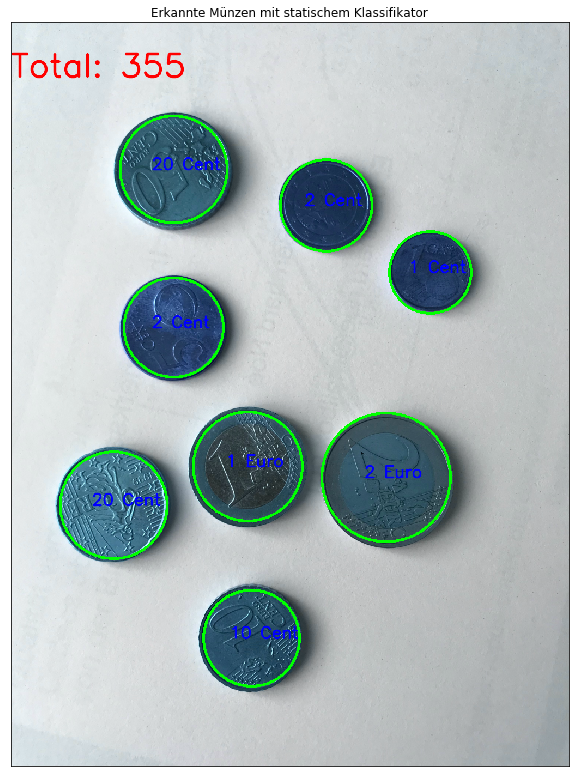

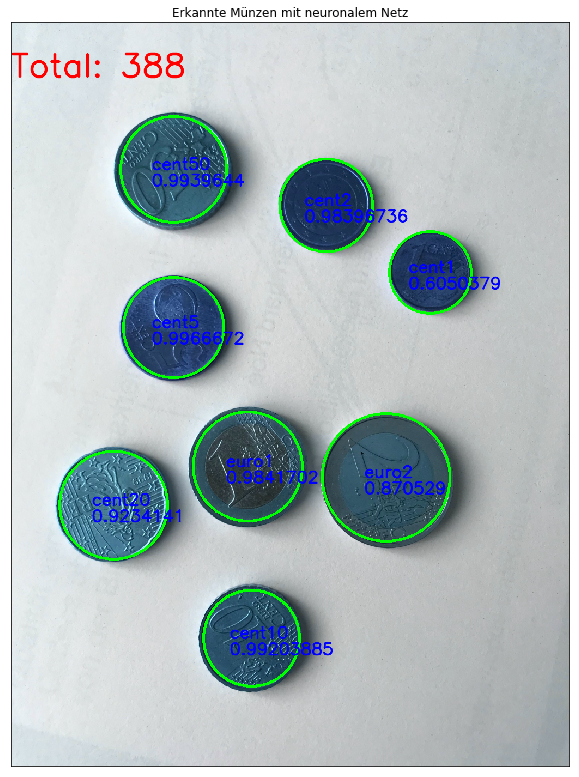

In [36]:
filename = "1_4.jpg"
smallest_coin_value = 1
# Anzeigen des Materials bei statischer Klassifizierung
debugMaterial = False
# Anzeigen des Vorgangs zur Materialerkennung bei statischer Klassifizierung
debugMaterialerkennung = False
# Anzeigen des Durchmessers bei statischer Klassifizierung
debugDurchmesser = False
# Anzeigen des Vorgangs zur Durchmessererkennung bei statischer Klassifizierung
debugDurchmessererkennung = False
# Anzeigen des Vorgangs im neuronalen Netz
debugNetz = False
# Anzeigen der Wahrscheinlichkeit der Erkannten Münze
debugProbability = True

# Datei einlesen
image = cv2.imread(filename)
if image is None:
    print("Unable to open " + filename)
    exit(-1)
    
# Größe anpassen
image = resize(image)
    
# Kopie erstellen für Zeichnungen
image_cpy = image.copy()
image_cpy2 = image.copy()

image_gray = gray(image)
image_gray = contrast_enhancement(image_gray)
blurred = gauss_blurr(image_gray)

#plot(blurred, "bild", (10,20), gray)

# Kreise im Bild suchen
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100, param1=200, param2=100, minRadius=60, maxRadius=120)

# Klassifizierung mit selbst entwickeltem Klassifikator
image_cpy = staticClassification(image_cpy, circles)
# Klassifizierung mit selbst trainiertem neuronalem Netz
image_cpy2 = neuronalClassification(image_cpy2, circles)
    
# Ergebnisse plotten
plot(image_cpy, 'Erkannte Münzen mit statischem Klassifikator', (10,20), _)
plot(image_cpy2, 'Erkannte Münzen mit neuronalem Netz', (10, 20), _)

# eventuell Speichern der Datei
#base = os.path.basename(filename)
#name = os.path.splitext(base)[0]
#cv2.imwrite(name+'_counted.JPG', image_cpy);